<a href="https://colab.research.google.com/github/r0hit91314/Equity_strategy_nifty50/blob/main/QI_STRAT_Long_iter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
warnings.filterwarnings("ignore")

# DOWNLOADING HISTORICAL DATA

In [2]:
nifty_50_tickers = [
    "ADANIENT", "ADANIPORTS", "APOLLOHOSP", "ASIANPAINT", "AXISBANK",
    "BAJAJ-AUTO", "BAJFINANCE", "BAJAJFINSV", "BHARTIARTL", "BPCL",
    "BRITANNIA", "CIPLA", "COALINDIA", "DIVISLAB", "DRREDDY", "EICHERMOT",
    "GRASIM", "HCLTECH", "HDFCBANK", "HDFCLIFE", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "ICICIBANK", "INDUSINDBK", "INFY", "ITC", "JSWSTEEL",
    "KOTAKBANK", "LT", "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBILIFE", "SBIN", "SUNPHARMA", "TATACONSUM",
    "TCS", "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "UPL", "ULTRACEMCO",
    "WIPRO", "SBICARD"
]

In [3]:
master_data = {}
for ticker in nifty_50_tickers:
    try:
        df = yf.download(ticker + ".NS", start="2020-01-01", end="2023-10-01")
        df.columns = ["Close" , "High", "Low", "Open", "Volume"]
        master_data[ticker] = df
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# PREPARING DATASETS WITH INDICATORS

In [4]:
def prepare_dataset(stock_data , short_ema, long_ema, adx_period, signal_ema):
    for ticker, df in stock_data.items():

        # ----- RSI ---
        delta = df['Close'].diff()

        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        # Use exponential moving average for smoothing
        avg_gain = gain.ewm(span= 14, adjust=False).mean()
        avg_loss = loss.ewm(span= 14, adjust=False).mean()

        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
        # --- MACD ---
        df['EMA_Short'] = df['Close'].ewm(span=short_ema, adjust=False).mean()
        df['EMA_Long'] = df['Close'].ewm(span=long_ema, adjust=False).mean()
        df['MACD'] = df['EMA_Short'] - df['EMA_Long']
        df['MACD_Signal'] = df['MACD'].ewm(span=signal_ema, adjust=False).mean()

        # --- ADX ---
        df['TR'] = df[['High', 'Close']].max(axis=1) - df[['Low', 'Close']].min(axis=1)

        df['+DM'] = df['High'].diff()
        df['-DM'] = -df['Low'].diff()
        df['+DM'] = df['+DM'].where((df['+DM'] > df['-DM']) & (df['+DM'] > 0), 0.0)
        df['-DM'] = df['-DM'].where((df['-DM'] > df['+DM']) & (df['-DM'] > 0), 0.0)

        tr14 = df['TR'].rolling(window=adx_period).sum()
        plus_dm14 = df['+DM'].rolling(window=adx_period).sum()
        minus_dm14 = df['-DM'].rolling(window=adx_period).sum()

        df["p_DI"] = 100 * (plus_dm14 / tr14)
        df["m_DI"] = 100 * (minus_dm14 / tr14)
        dx = 100 * (abs(df["p_DI"] - df["m_DI"]) / (df["p_DI"] + df["m_DI"]))
        df['ADX'] = dx.rolling(window=adx_period).mean()
        df['ADX_Slope'] = df['ADX'] - df['ADX'].shift(3)

        # FOR COMPUTING THE CAMPOSITE SCORE
        df["RS"] = rs
        df['EMA_slope'] = df['EMA_Long'] - df['EMA_Long'].shift(5)
        df['Volatility'] = df['Close'].pct_change().rolling(20).std()

        window = 35  # lookback period for z-score

        df['RS_score'] = (df['RS'] - df['RS'].rolling(window).mean()) / df['RS'].rolling(window).std()
        df['EMA_score'] = (df['EMA_slope'] - df['EMA_slope'].rolling(window).mean()) / df['EMA_slope'].rolling(window).std()
        df["ADX_score"] = (df['ADX'] - df['ADX'].rolling(window).mean()) / df['ADX'].rolling(window).std()

        df["Combined_score"] = 0.4*df["EMA_score"] + 0.3*df["RS_score"] + 0.3*df["ADX_score"]


        # Drop intermediate columns if not needed
        df.drop(columns=['TR' , "+DM" , "-DM"], inplace=True)
        df.dropna(inplace=True)  # Remove rows with NaN values

    return stock_data




In [5]:

def plot_macd_adx(df, ticker):
    plt.figure(figsize=(14, 10))


    # 1. Plot Closing Price (optional)
    plt.subplot(4, 1, 1)
    plt.plot(df['Close'], label='Close Price', color='blue')
    plt.title(f'{ticker} - Closing Price')
    plt.legend()
    plt.grid()

    # 2. Plot MACD and MACD Signal
    plt.subplot(4, 1, 2)
    plt.plot(df['MACD'], label='MACD', color='green')
    plt.plot(df['MACD_Signal'], label='Signal Line', color='red')
    plt.title(f'{ticker} - MACD vs Signal Line')
    plt.legend()
    plt.grid()

    # 3. Plot ADX
    plt.subplot(4, 1, 3)
    plt.plot(df['ADX'], label='ADX', color='purple')
    plt.axhline(25, linestyle='--', color='orange', label='Trend Threshold')
    plt.axhline(0, linestyle='--', color='grey', linewidth=1)
    plt.title(f'{ticker} - ADX')
    plt.legend()
    plt.grid()

    # 4. Plot RSI
    plt.subplot(4, 1, 4)
    plt.plot(df['RSI'], label='RSI', color='black')
    plt.axhline(70, linestyle='--', color='red', label='Overbought')
    plt.axhline(30, linestyle='--', color='green', label='Oversold')
    plt.title(f'{ticker} - RSI')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


### three months of data would be required to prepare the signals

### VISUALIZING THE INDICATORS

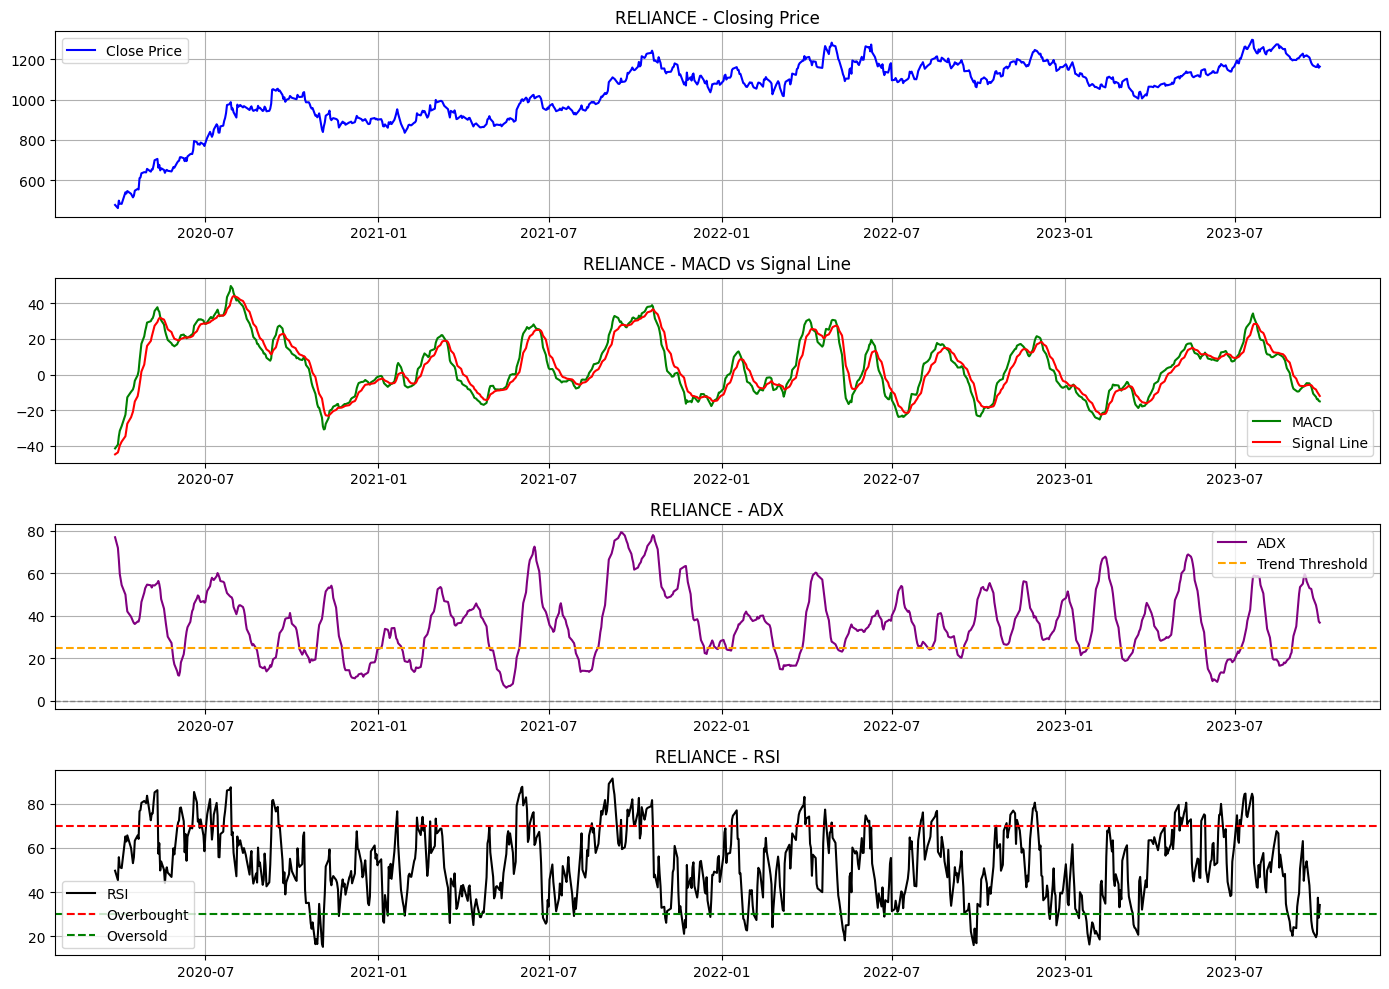

In [6]:
visualize = copy.deepcopy(master_data)
visualize = prepare_dataset(visualize, short_ema=13, long_ema=26, adx_period=14, signal_ema=9)
df = visualize["RELIANCE"]
plot_macd_adx(df, "RELIANCE")

# GENERATING SIGNALS FOR STRATEGY EXECUTION

In [7]:
def generate_signals_1(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i]:
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i]:
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [8]:
def generate_signals_2(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i] and (df["RSI"][i] < 70):
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i] and (df["RSI"][i] > 40):
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [9]:
def generate_signals_3(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i] and (df["ADX_Slope"][i] > 0) and (df["Combined_score"][i] > 0):
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i] and (df["ADX_Slope"][i] > 0):
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [10]:
def generate_signals_4(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i] and (df["ADX_Slope"][i] > 0) and (df["RSI"][i] < 70) :
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i] and (df["ADX_Slope"][i] > 0) and (df["RSI"][i] > 40):
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [11]:
def generate_signals_5(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if i == 0:
                continue
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df["MACD"][i] > 0) and (df["ADX_Slope"][i] > 0):
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1):
                df.at[df.index[i], 'exit'] = 1  # Exit position


    return stock_data

# Signal Generation Comparison Table

| Feature            | generate_signals_1                                                                                              | generate_signals_2                                                        | generate_signals_3                                                                                                    | generate_signals_4                                                                                                          |
|--------------------|----------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|
| **Buy Signal**     | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI`<br>- `RSI < 70`                      | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI` | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI`<br>- `ADX_Slope > 0`                    | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI`<br>- `ADX_Slope > 0`<br>- `RSI < 70`              |
| **Sell Signal**    | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI`<br>- `RSI > 40`                      | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI` | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI`<br>- `ADX_Slope > 0`                    | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI`<br>- `ADX_Slope > 0`<br>- `RSI > 40`              |
| **Extra Buy Filter**   | `RSI < 70`                                                                                                    | none                                                                     | `ADX_Slope > 0`                                                                                                      | `ADX_Slope > 0`<br>`RSI < 70`                                                                                              |
| **Extra Sell Filter**  | `RSI > 40`                                                                                                    | none                                                                     | `ADX_Slope > 0`                                                                                                      | `ADX_Slope > 0`<br>`RSI > 40`                                                                                              |
| **ADX Slope Used?**    | ✗                                                                                                           | ✗                                                                        | ✓                                                                                                                    | ✓                                                                                                                          |
| **RSI Used?**          | ✓                                                                                                           | ✗                                                                        | ✗                                                                                                                    | ✓                                                                                                                          |
| **Exit (long)**        | `MACD < MACD_Signal` after long<br>or `ADX < 25`                                                             | same as 1                                                               | same as 1                                                                                                            | same as 1                                                                                                                  |
| **Exit (short)**       | `MACD > MACD_Signal` after short<br>or `ADX < 25`                                                            | same as 1                                                               | same as 1                                                                                                            | same as 1                                                                                                                  |
| **General Approach**   | Full filter set (MACD, ADX, ±DI, RSI)                                                                        | Core filter set (MACD, ADX, ±DI)                                        | Adds `ADX_Slope > 0` as momentum filter                                                                              | Strongest filter combination (MACD, ADX, ±DI, ADX_Slope, RSI)                                                             |
| **Restrictiveness**    | Moderate                                                                                                     | Least Restrictive                                                       | Moderately Restrictive                                                                                                | Most Restrictive                                                                                                           |

---

# Analysis

| Version                     | Description                                                                                                                          |
|-----------------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| **generate_signals_1**       | Most "classic" oscillator filter: adds RSI filters to avoid overbought/oversold conditions. No ADX slope check, so includes both rising and falling trends while ADX > 30.      |
| **generate_signals_2**       | Minimal filter set: only MACD, ADX, ±DI used. No RSI or ADX slope filters. Generates most signals but with high risk of whipsaw.                                         |
| **generate_signals_3**       | Momentum confirmation added: requires ADX slope > 0 (rising trend strength), no RSI. Focuses on accelerating trends but may miss reversals or early entries.              |
| **generate_signals_4**       | Most restrictive: combines all filters — MACD, ADX, ±DI, ADX slope, and RSI. Trades only in strong, strengthening trends avoiding overbought/oversold. Fewer but higher quality signals. |

---

# Visual Summary Table

| SIGNAL VERSION | MACD/ADX/±DI | RSI Filter | ADX Slope | Stricter/Looser | Entry Focus                          |
|----------------|--------------|------------|-----------|-----------------|-------------------------------------|
| 1              | Yes          | Yes        | No        | Moderate        | Avoids overbought/oversold          |
| 2              | Yes          | No         | No        | Loose           | Most signals, least confirmation    |
| 3              | Yes          | No         | Yes       | Moderate        | Catches moves in accelerating trends|
| 4              | Yes          | Yes        | Yes       | Strict          | Needs strong & strengthening trend, not overbought/oversold |

---

# Recommendations

- Use **generate_signals_2** for rapid entries and high signal frequency, accepting more false signals.  
- Use **generate_signals_3** for higher conviction signals during strengthening trends but with risk of missing early moves.  
- Use **generate_signals_4** for highest signal quality and reduced whipsaw—best for conservative trading.  
- Use **generate_signals_1** as a balanced compromise with classic oscillator features.  

**Best practice:** Backtest all methods on your universe and select based on your trading style, risk tolerance, and objectives.


# BACKTESTING TO FIND THE BEST AND ROBUST WORKING SIGNAL OUT OF THESE 4


In [12]:
def compute_daily_returns(portfolio_values):
    returns = pd.Series(portfolio_values).pct_change().dropna()
    return returns

def sharpe_ratio(portfolio_values, risk_free_rate=0.0):
    returns = compute_daily_returns(portfolio_values)
    excess_returns = returns - (risk_free_rate / 252)
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

def sortino_ratio(portfolio_values, risk_free_rate=0.0):
    returns = compute_daily_returns(portfolio_values)
    excess_returns = returns - (risk_free_rate / 252)
    downside_std = returns[returns < 0].std()
    return np.sqrt(252) * excess_returns.mean() / downside_std if downside_std != 0 else np.nan

def profit_factor(portfolio_values):
    returns = compute_daily_returns(portfolio_values)
    gross_profit = returns[returns > 0].sum()
    gross_loss = -returns[returns < 0].sum()
    return gross_profit / gross_loss if gross_loss != 0 else np.inf

def max_drawdown(portfolio_values):
    series = pd.Series(portfolio_values)
    cumulative_max = series.cummax()
    drawdowns = (series - cumulative_max) / cumulative_max
    return drawdowns.min()  # Most negative value = max drawdown

def calculate_pnl(portfolio_values):
    return portfolio_values[-1] - portfolio_values[0]

def calculate_cagr(portfolio_values, days=None):
    if days is None:
        days = len(portfolio_values)  # Assume each value is 1 day apart
    start_value = portfolio_values[0]
    end_value = portfolio_values[-1]
    return (end_value / start_value) ** (252 / days) - 1


### CODE TO EXECUTE STRATEGY

In [13]:
def assign_weights(candidates , cash_balance, transaction_cost = 0.001 , slippage_cost = 0.0005):
    score_vals = np.array([score for _, score in candidates])
    weights = score_vals / np.sum(score_vals) if len(score_vals) > 0 else np.array([])
    # weights = np.ones(len(candidates)) / len(candidates)
    allocations = weights * (cash_balance)*(1 - transaction_cost - slippage_cost)
    return allocations

def positions(stock_data , buy_candidates , long_allocations , current_date):
    long_positions = {}
    for (ticker, _), alloc in zip(buy_candidates, long_allocations):
        entry_price = stock_data[ticker].loc[current_date, 'Close']
        long_positions[ticker] = (alloc, entry_price)
    return long_positions

def run_strategy(stock_data, initial_amount=10000000, no_of_stocks=10, trans_cost=0.001, slip_cost=0.0005, trailing_percent=0.5):

    portfolio_value = []
    cash_balance = initial_amount

    # Positions dictionary:
    # ticker: { "alloc": allocated amount,
    #           "entry_price": price at entry,
    #           "max_price": highest price seen since entry }
    positions_dict = {}

    tickers = list(stock_data.keys())
    dates = stock_data[tickers[0]].index
    day = 0

    while day < len(dates) - 1:
        current_date = dates[day]
        buy_candidates = []

        # Step 1: Select candidates
        for ticker in tickers:
            df = stock_data[ticker]
            if current_date not in df.index:
                continue
            row = df.loc[current_date]
            signal = row.get('Signal', 0)
            score = row.get('Combined_score', np.nan)
            if signal == 1 and not np.isnan(score):
                buy_candidates.append((ticker, score))

        # Step 2: Allocate
        buy_candidates = sorted(buy_candidates, key=lambda x: x[1], reverse=True)[:no_of_stocks]
        allocations = assign_weights(buy_candidates, cash_balance,  transaction_cost=trans_cost, slippage_cost=slip_cost)

        # Step 3: Enter or add to positions
        for (ticker, _), alloc in zip(buy_candidates, allocations):
            if alloc <= 0:
                continue

            current_price = stock_data[ticker].loc[current_date, 'Close']

            if ticker in positions_dict:
                old_alloc = positions_dict[ticker]["alloc"]
                old_price = positions_dict[ticker]["entry_price"]
                total_alloc = old_alloc + alloc
                avg_price = (old_alloc * old_price + alloc * current_price) / total_alloc
                max_price = max(positions_dict[ticker]["max_price"], current_price)
                positions_dict[ticker] = {
                    "alloc": total_alloc,
                    "entry_price": avg_price,
                    "max_price": max_price,
                }
                cash_balance -= alloc
            else:
                positions_dict[ticker] = {
                    "alloc": alloc,
                    "entry_price": current_price,
                    "max_price": current_price,
                }
                cash_balance -= alloc

        # Step 4: Track portfolio and exit positions on trailing stop loss or exit signal
        current_day = dates[day + 1]
        day_value = cash_balance
        remove_list = []

        for ticker, pos in positions_dict.items():
            df = stock_data[ticker]
            if current_day not in df.index:
                day_value += pos["alloc"]
                continue

            current_price = df.loc[current_day, 'Close']

            # Update max price for trailing stop
            pos["max_price"] = max(pos["max_price"], current_price)
            trailing_stop_price = pos["max_price"] * (1 - trailing_percent)

            ret = current_price / pos["entry_price"]
            position_value = pos["alloc"] * ret
            day_value += position_value

            # Exit condition: exit signal or price below trailing stop price
            if df.loc[current_day].get('exit', 0) == 1 or current_price < trailing_stop_price:
                sell_value = position_value * (1 - trans_cost - slip_cost)
                cash_balance += sell_value
                remove_list.append(ticker)

        for ticker in remove_list:
            del positions_dict[ticker]

        portfolio_value.append(day_value)
        day += 1

    return portfolio_value

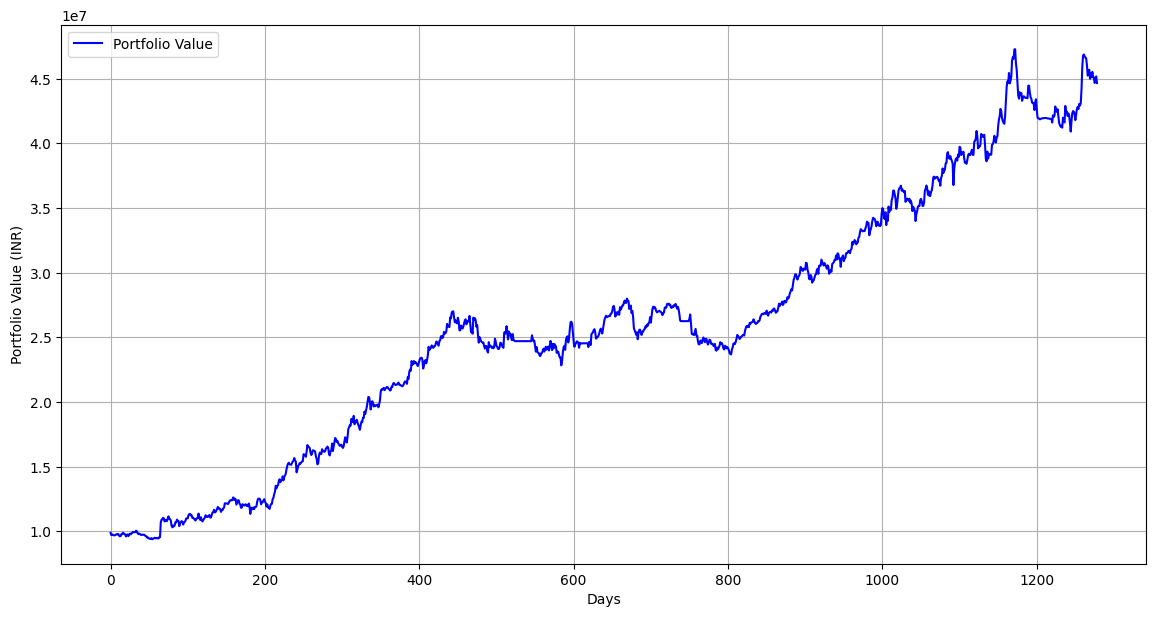

In [16]:
test_portfolio = []
improvise = backtest("2019-01-01", "2020-01-01" ,"2019-10-01" , "2025-03-01" , nifty_50_tickers , (24, 13, 9, 15) , True , 10000000 , test_portfolio )
#hardcoded_params = (long_ema , short_ema , signal_period , adx_period , holding_days)


# FINALLY BACKTESTING BY CHOOSING THE BEST PARAMS FOR 1 year TRAINING AND NEXT 6 MONTH FOR TESTING ON A ROLLING BASIS FROM TP: 2020 TO 2025

In [17]:
import itertools

def best_params_fast(start_date, end_date , ticker_list):
    # 1. Download all required data ONCE outside the loop
    training_data = {}
    for ticker in ticker_list:
        try:
            df = yf.download(ticker + ".NS", start=start_date, end=end_date , progress=False)
            df.columns = ["Close" , "High", "Low", "Open", "Volume"]
            training_data[ticker] = df
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")

    long_ema = [24,26, 28]
    short_ema = [11,13,15]
    signal_ema = [8, 9, 10]
    adx_period = [13,15]

    best_value = -float("inf")
    best_params = None

    # Use itertools.product for clean parameter grid search
    for long_macd, short, signal, adx in itertools.product(long_ema, short_ema, signal_ema, adx_period):
        # Filter out illogical combos
        if short >= long_macd or signal > short:
            continue

        data = copy.deepcopy(training_data)
        data = prepare_dataset(data, short_ema=short, long_ema=long_macd, adx_period=adx, signal_ema=signal)
        data = generate_signals_3(data)
        portfolio = run_strategy(stock_data=data, initial_amount=10000000)
        sharpe = sharpe_ratio(portfolio)
        print(f"for parameters {long_macd} , {short} , {signal} , {adx} the sharpe ratio was: {sharpe}")

        if sharpe > best_value:
            best_value = sharpe
            best_params = (long_macd, short, signal, adx)
            print("New best:", best_params, "with portfolio value:", best_value)

    print("Final best parameters:", best_params)
    return best_params

def backtest(training_start , training_end , test_start , test_end , ticker_list , hardcoded_parameters , hardcoded_parameters_bool, init_amount , final_portfolio):
  if hardcoded_parameters_bool:
    best_parameters = hardcoded_parameters
  else:
    best_parameters = best_params_fast(training_start, training_end , ticker_list)
  test_data = {}
  error = 50
  while error > 5:
      test_data = {}
      error = 0
      for ticker in ticker_list:
          try:
              df = yf.download(ticker + ".NS", start= test_start, end= test_end , progress= False)
              df.columns = ["Close" , "High", "Low", "Open", "Volume"]
              test_data[ticker] = df
          except Exception as e:
              #print(f"Error downloading {ticker}: {e}")
              error += 1

  test_data = prepare_dataset(test_data, short_ema=best_parameters[1], long_ema=best_parameters[0], adx_period=best_parameters[3], signal_ema=best_parameters[2])
  test_data = generate_signals_3(test_data)
  portfolio = run_strategy(stock_data=test_data , initial_amount = init_amount)
  final_portfolio.extend(portfolio)
  plt.figure(figsize=(14, 7))
  plt.plot(final_portfolio, label='Portfolio Value', color='blue')
  plt.xlabel('Days')
  plt.ylabel('Portfolio Value (INR)')
  plt.legend()
  plt.grid()
  return portfolio











In [18]:
# 📅 NIFTY 50 Constituents - Historical Timeline
# source wikepedia

# November 2019
tickers_nov2019 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "VEDL", "WIPRO", "YESBANK", "ZEEL"
]

# March 19, 2020
tickers_mar2020 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "VEDL", "WIPRO", "SHREECEM", "ZEEL"
]

# July 31, 2020
tickers_jul2020 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "ZEEL"
]

# September 25, 2020
tickers_sep2020 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "SBILIFE"
]

# March 31, 2021
tickers_mar2021 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "SBILIFE"
]

# March 31, 2022
tickers_mar2022 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "SBILIFE"
]

# September 30, 2022
tickers_sep2022 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# July 13, 2023
tickers_jul2023 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# March 28, 2024
tickers_mar2024 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "SHRIRAMFIN", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# September 30, 2024
tickers_sep2024 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "BEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "SHRIRAMFIN", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# March 28, 2025
tickers_mar2025 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "BEL", "JIOFIN", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "SHRIRAMFIN", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


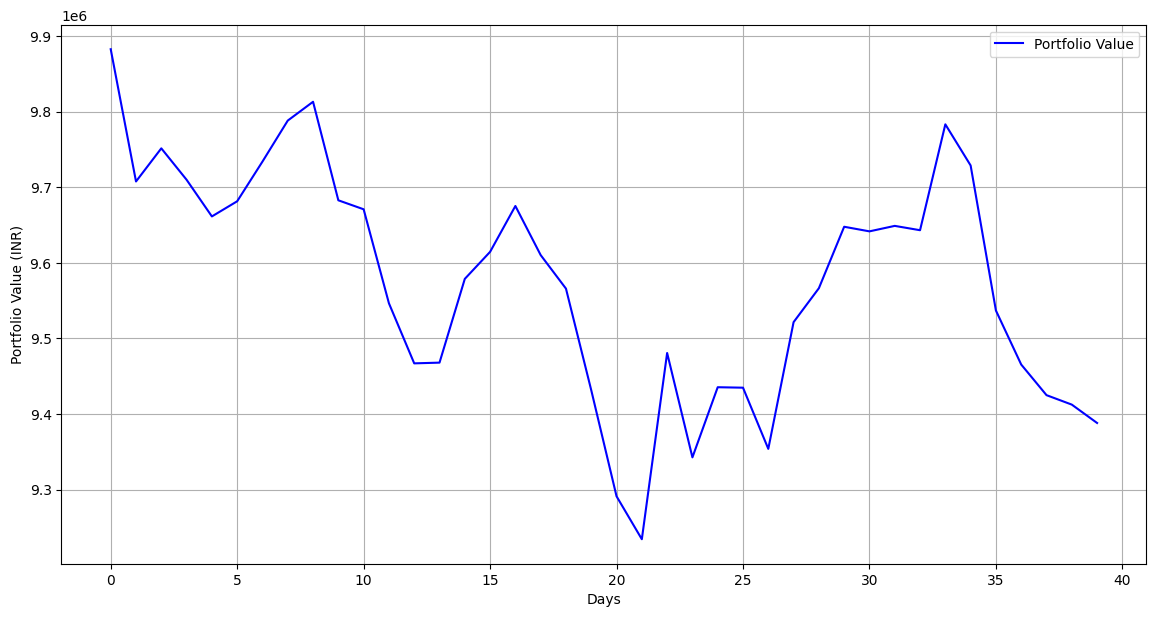

In [19]:
final_portfolio = []
portfolio_iter1 = backtest("2019-01-01", "2020-01-01" ,"2019-10-01" , "2020-03-01" , tickers_nov2019 , (24, 13, 9, 15) , True , 10000000 , final_portfolio)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


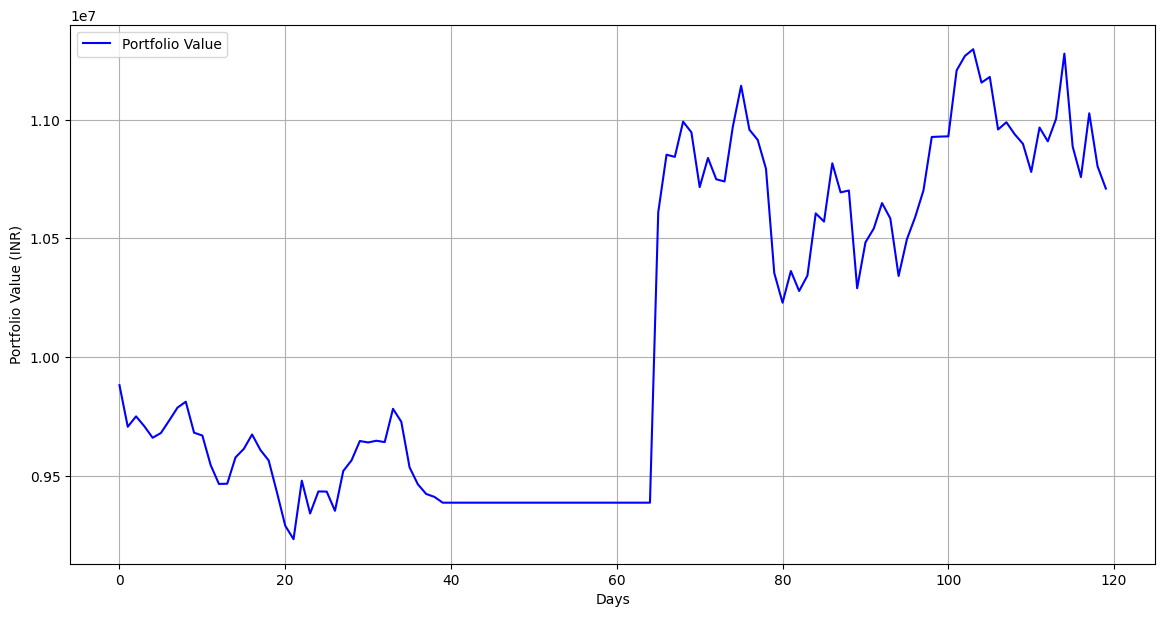

In [20]:
portfolio_iter2 = backtest("2019-03-01", "2020-03-01" ,"2019-12-01" , "2020-07-01" , tickers_mar2020 , (24, 13, 9, 15) , True , portfolio_iter1[-1] , final_portfolio)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


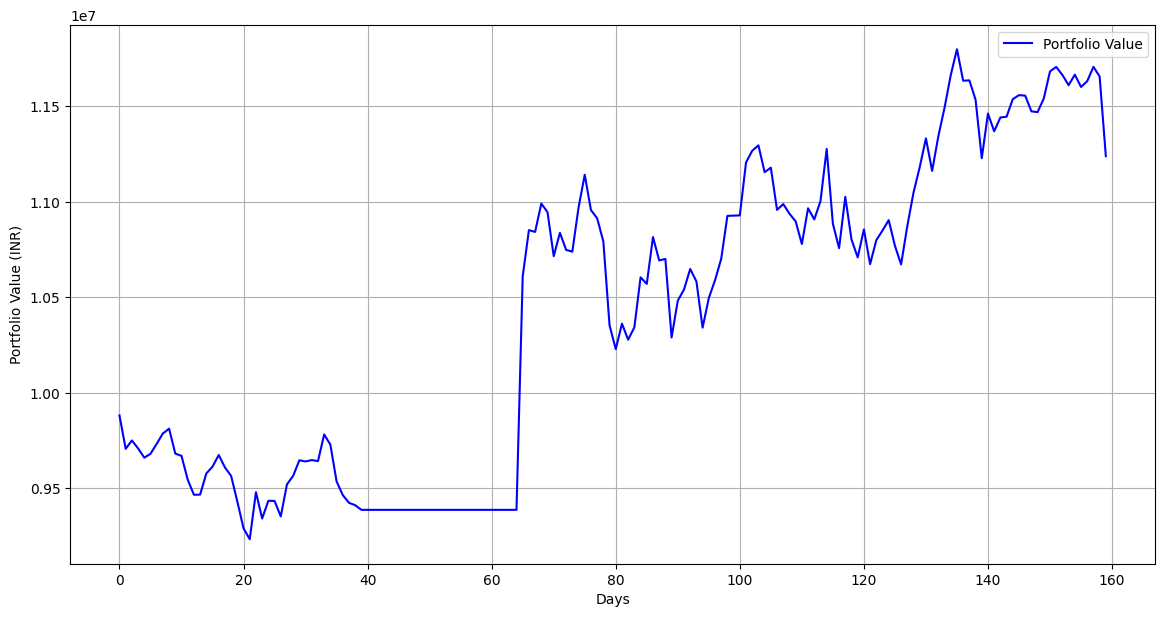

In [21]:
portfolio_iter3 = backtest("2019-07-01", "2020-07-01" ,"2020-04-01" ,  "2020-09-01" , tickers_jul2020 , (24, 13, 9, 15) , True , portfolio_iter2[-1], final_portfolio)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


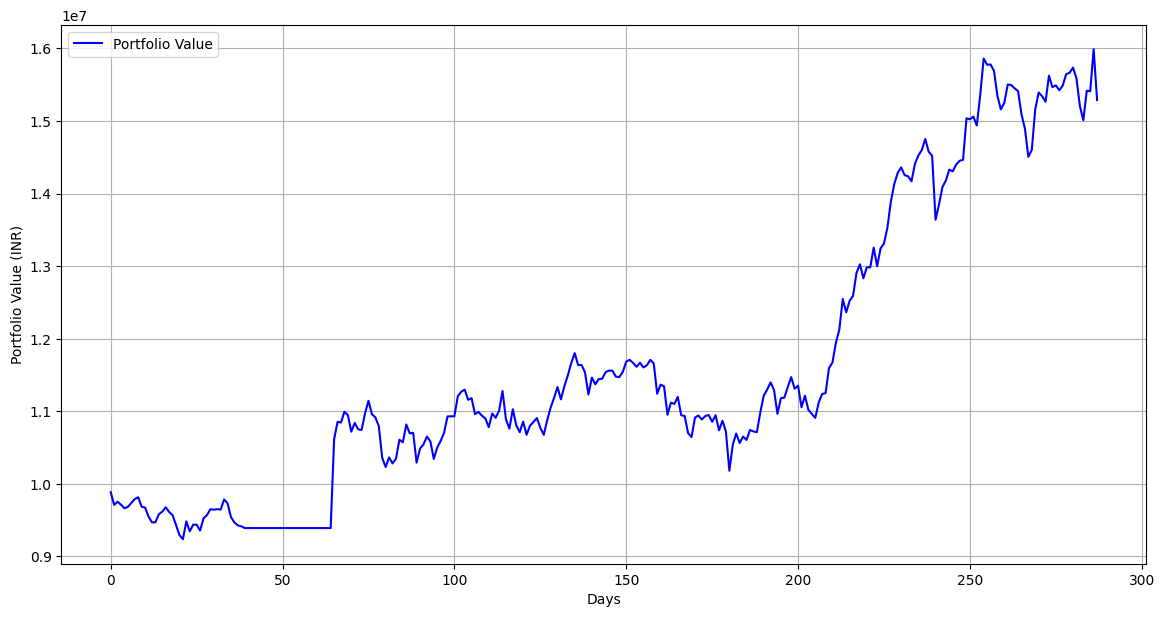

In [22]:
portfolio_iter4 = backtest("2019-09-01", "2020-09-01" ,"2020-06-01" ,  "2021-03-01" , tickers_sep2020 , (24, 13, 9, 15) , True , portfolio_iter3[-1] , final_portfolio)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


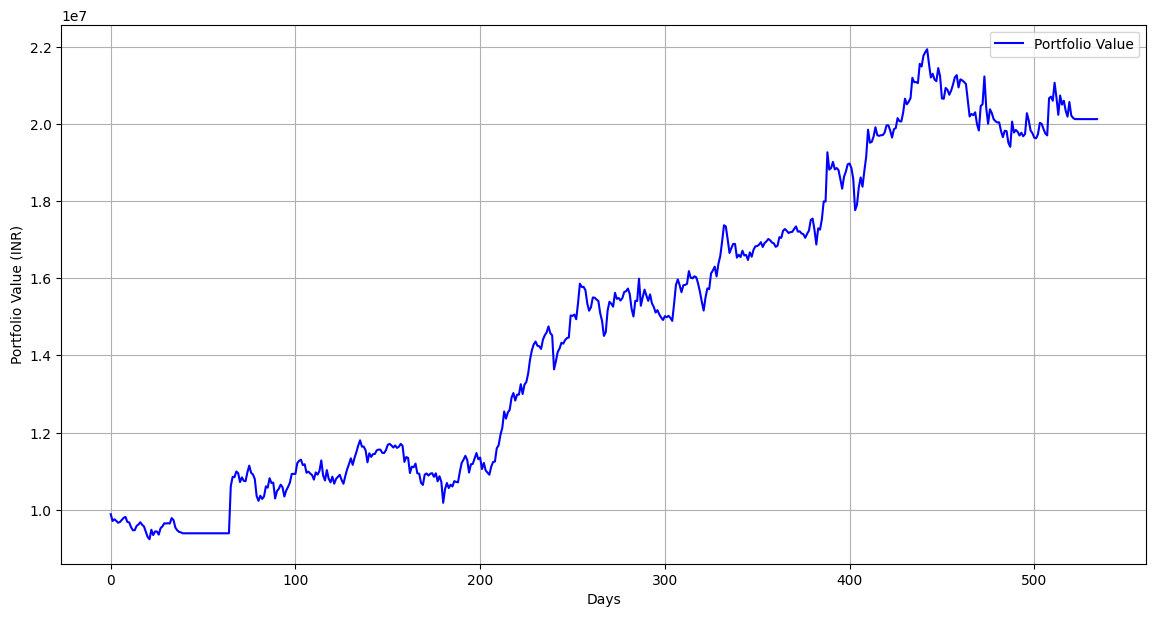

In [23]:
portfolio_iter5 = backtest("2020-03-01", "2021-03-01" ,"2020-12-01" ,  "2022-03-01" , tickers_mar2021 , (24, 13, 9, 15) , True , portfolio_iter4[-1], final_portfolio)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


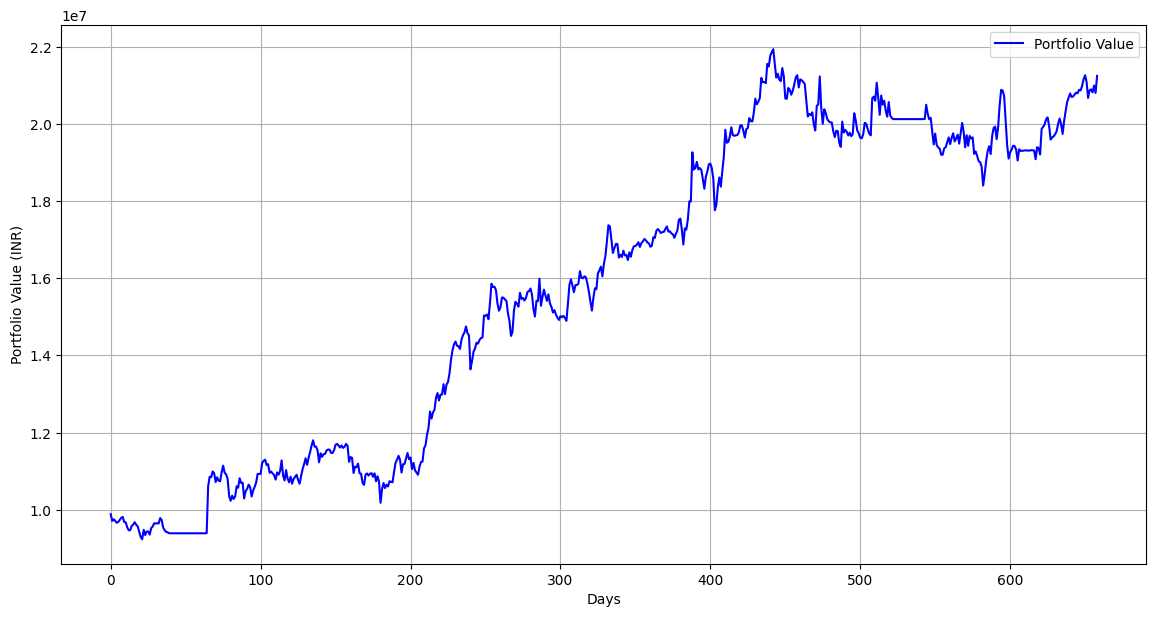

In [24]:
portfolio_iter6 = backtest("2021-03-01", "2022-03-01" ,"2021-12-01" ,  "2022-09-01" , tickers_mar2022 , (24, 13, 9, 15) , True , portfolio_iter5[-1] , final_portfolio)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


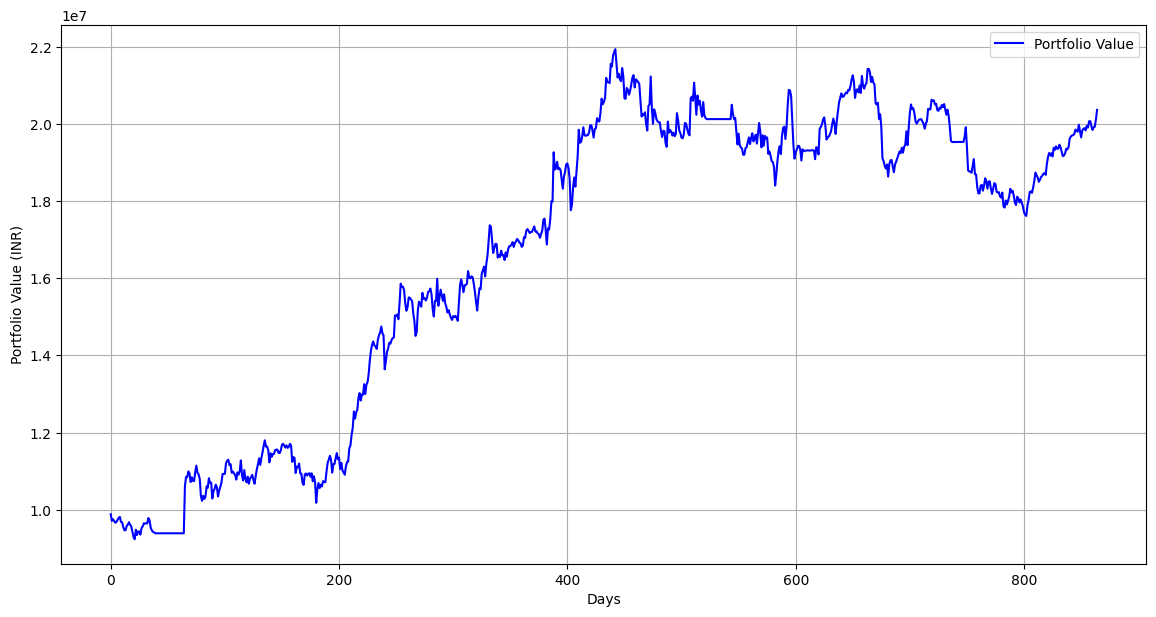

In [25]:
portfolio_iter7 = backtest("2021-09-01", "2022-09-01" ,"2022-06-01" ,  "2023-07-01" , tickers_sep2022 , (24, 13, 9, 15) , True , portfolio_iter6[-1], final_portfolio)


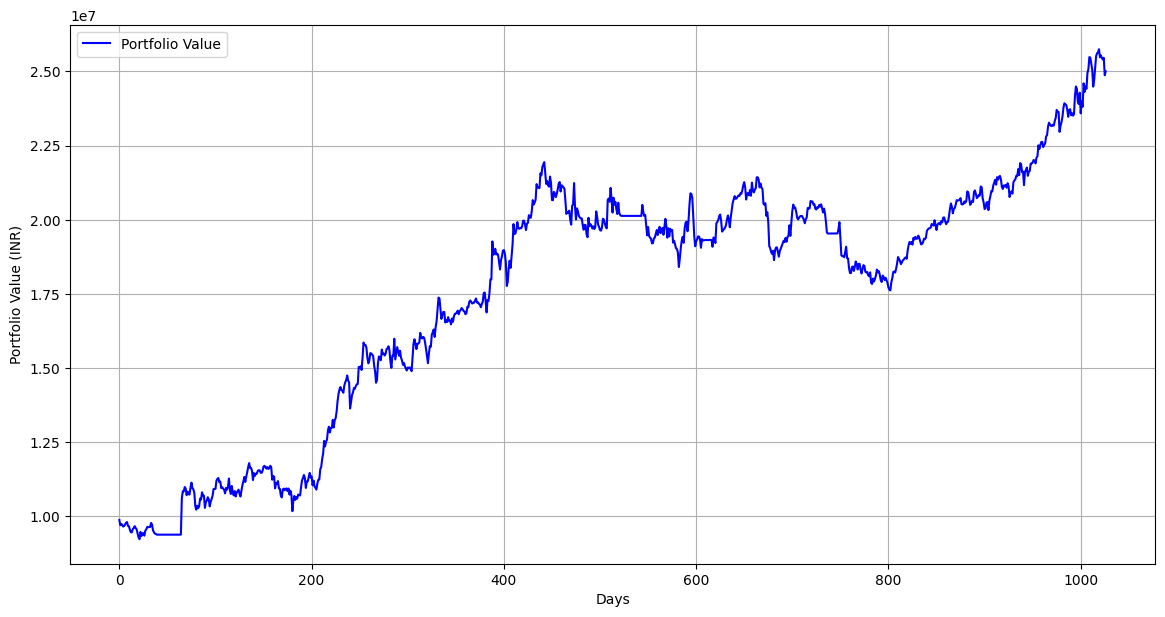

In [26]:
portfolio_iter8 = backtest("2022-07-01", "2023-07-01" ,"2023-04-01" ,  "2024-03-01" , tickers_jul2023 , (24, 13, 9, 15) , True , portfolio_iter7[-1] , final_portfolio)


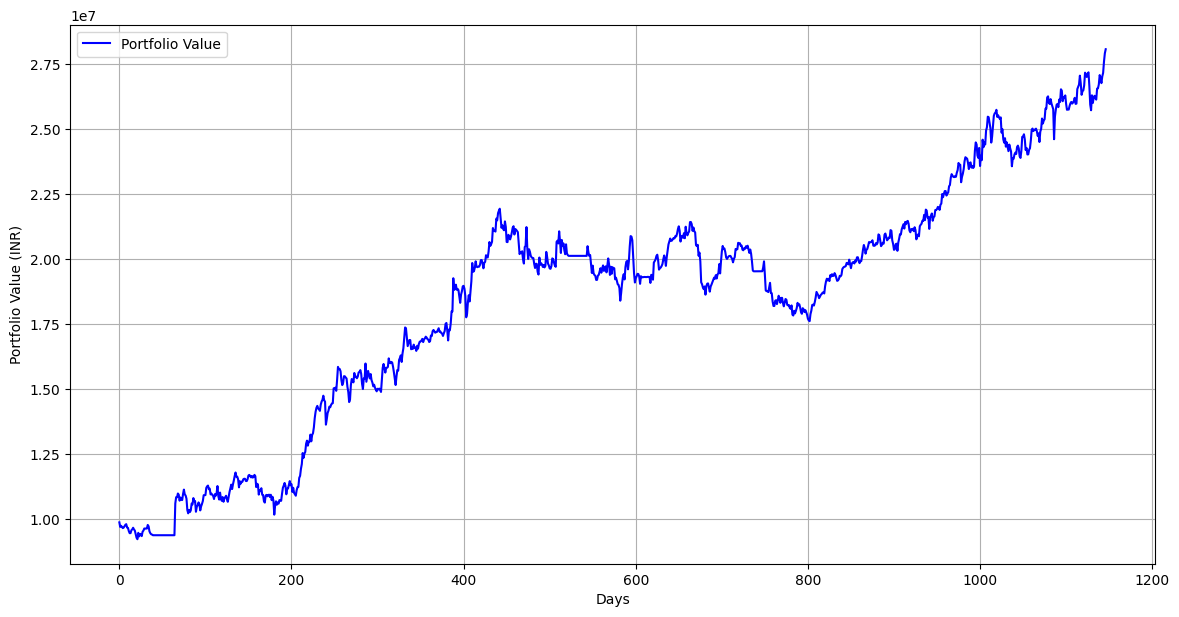

In [27]:
portfolio_iter9 = backtest("2023-03-01", "2024-03-01" ,"2023-12-01" ,  "2024-09-01" , tickers_mar2024 , (24, 13, 9, 15) , True, portfolio_iter8[-1] , final_portfolio)


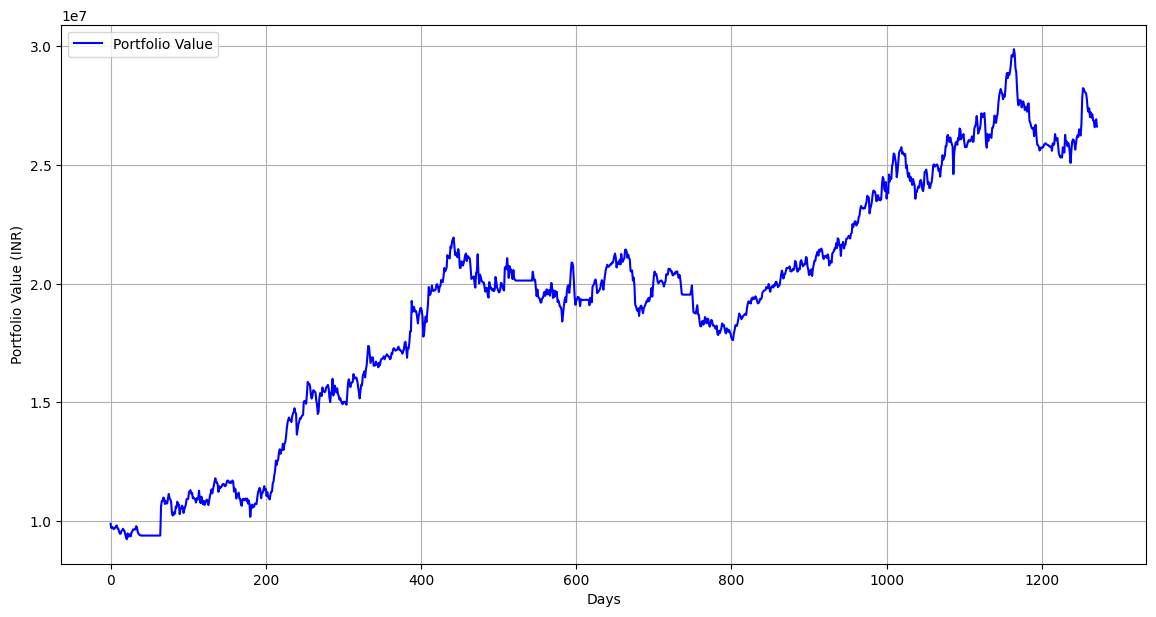

In [28]:
portfolio_iter10 = backtest("2023-09-01", "2024-09-01" ,"2024-06-01" ,  "2025-03-01" , tickers_sep2024 , (24, 13, 9, 15) , True , portfolio_iter9[-1] , final_portfolio)


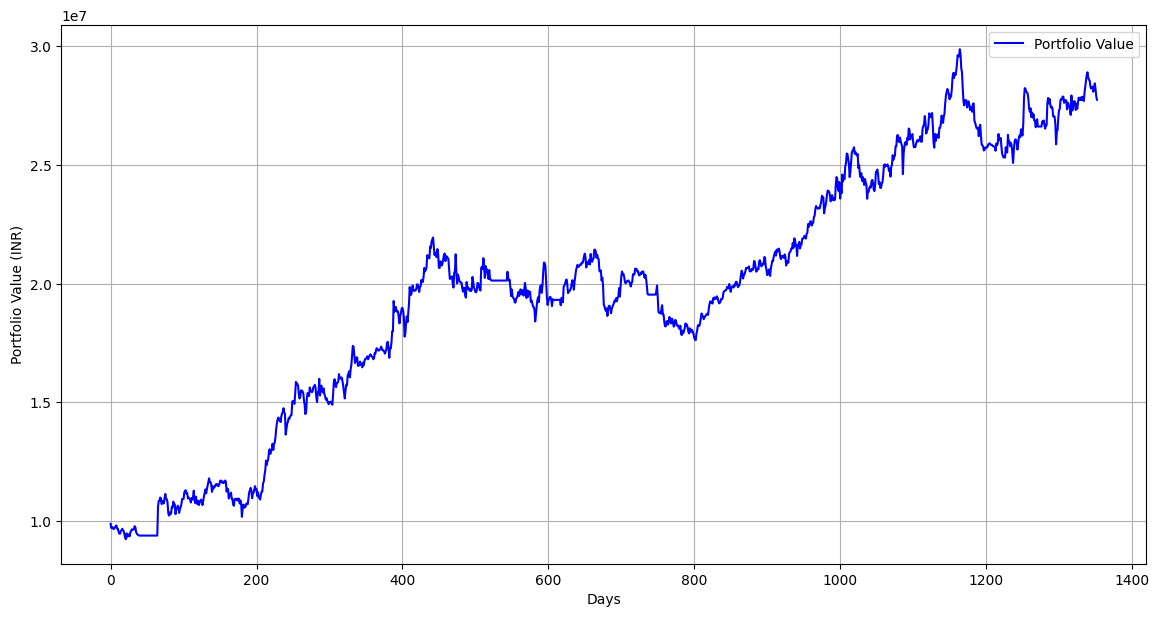

In [29]:
portfolio_iter11 = backtest("2024-03-01", "2025-03-01" ,"2024-12-01" ,  "2025-07-01" , tickers_mar2025 , (24, 13, 9, 15) , True, portfolio_iter10[-1] , final_portfolio)


# CAMPARISION WITH BENCHMARK

[*********************100%***********************]  1 of 1 completed


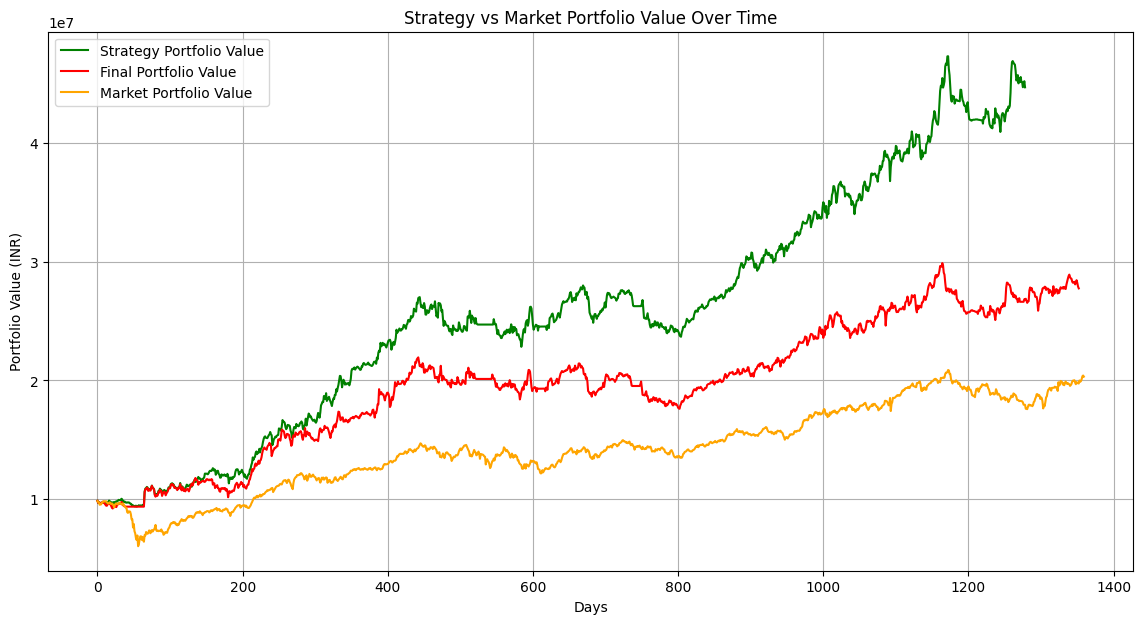

In [30]:
market_data = yf.download("^NSEI", start="2020-01-01", end="2025-07-01")
market_data.columns = ["Close" , "High", "Low", "Open", "Volume"]
market_portfolio = [10000000*0.985]
for day in range(1,len(market_data)):
    returns = market_data['Close'][day] / market_data['Close'][0]
    market_portfolio.append(market_portfolio[0] * returns*0.985)

plt.figure(figsize=(14, 7))
plt.plot(improvise , label='Strategy Portfolio Value', color='green')
plt.plot(final_portfolio, label='Final Portfolio Value', color='red')
plt.plot(market_portfolio, label='Market Portfolio Value', color='orange')
plt.title('Strategy vs Market Portfolio Value Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid()
plt.show()

In [31]:
def strategy_evaluation(portfolios_dict):
    metric_df = {}
    for name, portfolio in portfolios_dict.items():
        sharpe = sharpe_ratio(portfolio)
        sortino = sortino_ratio(portfolio)
        profit = profit_factor(portfolio)
        drawdown = max_drawdown(portfolio)
        cagr = calculate_cagr(portfolio)
        pnl = calculate_pnl(portfolio)

        metric_df[name] = {  # ✅ name as key
            "Sharpe Ratio": sharpe,
            "Sortino Ratio": sortino,
            "Profit Factor": profit,
            "Max Drawdown": drawdown,
            "CAGR": cagr,
            "Total PnL": pnl
        }
    return metric_df

portfolios = {
    "Market Portfolio": market_portfolio,
    "Strategy 1": improvise,
    "Strategy 2": final_portfolio
}

comparison_df = pd.DataFrame(strategy_evaluation(portfolios)).T
comparison_df


,Sharpe Ratio,Sortino Ratio,Profit Factor,Max Drawdown,CAGR,Total PnL
Market Portfolio,0.810828,0.930680,1.169675,-0.384683,0.143617,1.047200e+07
Strategy 1,1.641975,2.528488,1.341465,-0.154705,0.345891,3.476741e+07
Strategy 2,1.080600,1.623669,1.219041,-0.196992,0.211994,1.786235e+07


In [ ]:
from collections import defaultdict
import itertools

# Parameters to test (example)
long_ema = [22, 26, 30, 34]
short_ema = [7,11, 13]
macd_signal = [9]
adx_periods = [15, 16]
holding_periods = [2, 6,8]

# Parameter grid (using itertools.product)
param_grid = list(itertools.product(long_ema, short_ema, macd_signal, adx_periods))

# Initialize count dictionaries for each metric and strategy
# The keys will be place (1 to 4), values are counts of how many times a strategy ranked there
metrics = ['sharpe', 'max_dd', 'cagr']  # example metric keys you have
strategies = ['strat_1', 'strat_2', 'strat_3', 'strat_4']

# Use dictionaries of dicts: metric -> strategy -> place counts
place_counts = {
    metric: {strategy: defaultdict(int) for strategy in strategies}
    for metric in metrics
}

# Suppose you have your parameter grid
# and in each iteration you compute portfolios and metrics like this:
for params in param_grid:
    long_ema, short_ema, sig_ema, adx_period = params

    data_copy = copy.deepcopy(master_data)
    data_prepared = prepare_dataset(data_copy, short_ema=short_ema, long_ema=long_ema, adx_period=adx_period, signal_ema=sig_ema)

    data_prepared_1 = copy.deepcopy(data_prepared)
    data_prepared_2 = copy.deepcopy(data_prepared)
    data_prepared_3 = copy.deepcopy(data_prepared)
    data_prepared_4 = copy.deepcopy(data_prepared)

    data_prepared_1 = generate_signals_1(data_prepared_1)
    data_prepared_2 = generate_signals_2(data_prepared_2)
    data_prepared_3 = generate_signals_3(data_prepared_3)
    data_prepared_4 = generate_signals_4(data_prepared_4)

    for holding in holding_periods:
        print(f"Running strategies with params: {params}, holding period: {holding}")


        portfolio_values_1 = run_strategy_stoploss(holding_period=holding, stock_data=data_prepared_1)
        portfolio_values_2 = run_strategy_stoploss(holding_period=holding, stock_data=data_prepared_2)
        portfolio_values_3 = run_strategy_stoploss(holding_period=holding, stock_data=data_prepared_3)
        portfolio_values_4 = run_strategy_stoploss(holding_period=holding, stock_data=data_prepared_4)

        # Calculate metrics
        metric_values = {
            'strat_1': {
                'sharpe': sharpe_ratio(portfolio_values_1),
                'max_dd': max_drawdown(portfolio_values_1),
                'cagr': calculate_cagr(portfolio_values_1),
            },
            'strat_2': {
                'sharpe': sharpe_ratio(portfolio_values_2),
                'max_dd': max_drawdown(portfolio_values_2),
                'cagr': calculate_cagr(portfolio_values_2),
            },
            'strat_3': {
                'sharpe': sharpe_ratio(portfolio_values_3),
                'max_dd': max_drawdown(portfolio_values_3),
                'cagr': calculate_cagr(portfolio_values_3),
            },
            'strat_4': {
                'sharpe': sharpe_ratio(portfolio_values_4),
                'max_dd': max_drawdown(portfolio_values_4),
                'cagr': calculate_cagr(portfolio_values_4),
            },
        }

        for metric in metrics:
            # Extract metric values per strategy
            strat_metric_values = {s: vals[metric] for s, vals in metric_values.items()}

            # For max drawdown, smaller is better (rank ascending)
            # For sharpe and cagr, larger is better (rank descending)
            reverse_rank = True if metric in ['sharpe', 'cagr'] else False

            # Sort strategies by metric
            sorted_strats = sorted(strat_metric_values.items(), key=lambda x: x[1], reverse=reverse_rank)

            # Assign ranks (1 to 4) and increment counts
            for rank, (strategy, value) in enumerate(sorted_strats, start=1):
                place_counts[metric][strategy][rank] += 1

# After running all parameter combos, print summary counts:

for metric in metrics:
    print(f"\nRanking counts for metric: {metric}")
    print(f"{'Strategy':>10} | {'1st':>5} {'2nd':>5} {'3rd':>5} {'4th':>5}")
    print("-"*36)
    for strat in strategies:
        counts = place_counts[metric][strat]
        print(f"{strat:>10} | {counts[1]:5d} {counts[2]:5d} {counts[3]:5d} {counts[4]:5d}")


TypeError: 'DataFrame' object is not callable

In [ ]:
# from collections import defaultdict
# import itertools

# # Parameters to test (example)
# long_ema = [18, 22, 26, 30, 34]
# short_ema = [7, 9, 11, 13]
# macd_signal = [9]
# adx_periods = [14, 15, 16]
# holding_periods = [2, 6, 7, 8]

# # Parameter grid (using itertools.product)
# param_grid = list(itertools.product(long_ema, short_ema, macd_signal, adx_periods))

# # Initialize count dictionaries for each metric and strategy
# # The keys will be place (1 to 4), values are counts of how many times a strategy ranked there
# metrics = ['sharpe', 'max_dd', 'cagr']  # example metric keys you have
# strategies = ['WITHOUT_STOPLOSS', 'WITH_STOPLOSS']

# # Use dictionaries of dicts: metric -> strategy -> place counts
# place_counts = {
#     metric: {strategy: defaultdict(int) for strategy in strategies}
#     for metric in metrics
# }

# # Suppose you have your parameter grid
# # and in each iteration you compute portfolios and metrics like this:
# for params in param_grid:
#     long_ema, short_ema, sig_ema, adx_period = params

#     data_copy = copy.deepcopy(master_data)
#     data_prepared = prepare_dataset(data_copy, short_ema=short_ema, long_ema=long_ema, adx_period=adx_period, signal_ema=sig_ema)
#     data_prepared = generate_signals_1(data_prepared)


#     for holding in holding_periods:
#         print(f"Running strategies with params: {params}, holding period: {holding}")


#         portfolio_values_without_stoploss = run_strategy_long(holding_period=holding, stock_data=data_prepared)
#         portfolio_values_with_stoploss = run_strategy_stoploss(holding_period=holding, stock_data=data_prepared)


#         # Calculate metrics
#         metric_values = {
#             'WITHOUT_STOPLOSS': {
#                 'sharpe': sharpe_ratio(portfolio_values_without_stoploss),
#                 'max_dd': max_drawdown(portfolio_values_without_stoploss),
#                 'cagr': calculate_cagr(portfolio_values_without_stoploss),
#             },
#             'WITH_STOPLOSS': {
#                 'sharpe': sharpe_ratio(portfolio_values_with_stoploss),
#                 'max_dd': max_drawdown(portfolio_values_with_stoploss),
#                 'cagr': calculate_cagr(portfolio_values_with_stoploss),
#             },
#         }

#         for metric in metrics:
#             # Extract metric values per strategy
#             strat_metric_values = {s: vals[metric] for s, vals in metric_values.items()}

#             # For max drawdown, smaller is better (rank ascending)
#             # For sharpe and cagr, larger is better (rank descending)
#             reverse_rank = True if metric in ['sharpe', 'cagr'] else False

#             # Sort strategies by metric
#             sorted_strats = sorted(strat_metric_values.items(), key=lambda x: x[1], reverse=reverse_rank)

#             # Assign ranks (1 to 4) and increment counts
#             for rank, (strategy, value) in enumerate(sorted_strats, start=1):
#                 place_counts[metric][strategy][rank] += 1

# # After running all parameter combos, print summary counts:

# for metric in metrics:
#     print(f"\nRanking counts for metric: {metric}")
#     print(f"{'Strategy':>10} | {'1st':>5} {'2nd':>5} {'3rd':>5} {'4th':>5}")
#     print("-"*36)
#     for strat in strategies:
#         counts = place_counts[metric][strat]
#         print(f"{strat:>10} | {counts[1]:5d} {counts[2]:5d} {counts[3]:5d} {counts[4]:5d}")


Running strategies with params: (18, 7, 9, 14), holding period: 2
Running strategies with params: (18, 7, 9, 14), holding period: 6
Running strategies with params: (18, 7, 9, 14), holding period: 7
Running strategies with params: (18, 7, 9, 14), holding period: 8
Running strategies with params: (18, 7, 9, 15), holding period: 2
Running strategies with params: (18, 7, 9, 15), holding period: 6
Running strategies with params: (18, 7, 9, 15), holding period: 7
Running strategies with params: (18, 7, 9, 15), holding period: 8
Running strategies with params: (18, 7, 9, 16), holding period: 2
Running strategies with params: (18, 7, 9, 16), holding period: 6
Running strategies with params: (18, 7, 9, 16), holding period: 7
Running strategies with params: (18, 7, 9, 16), holding period: 8
Running strategies with params: (18, 9, 9, 14), holding period: 2
Running strategies with params: (18, 9, 9, 14), holding period: 6
Running strategies with params: (18, 9, 9, 14), holding period: 7
Running st

# Why Continue with strat_1?

We are proceeding with **strat_1** because it demonstrates the strongest performance for investors with a higher risk tolerance.

- **Dominates Sharpe Ratio:** strat_1 has the highest number of first-place rankings in risk-adjusted returns, showing it efficiently converts risk into reward.
- **Top CAGR Performance:** Tied for the lead in annualized returns, it maximizes long-term growth potential.
- **Acceptable Drawdowns for Our Risk Profile:** Although it experiences more frequent and deeper drawdowns, our investment approach tolerates these volatilities. The trade-off favors maximizing gains over minimizing drawdowns.

# When and Why to Consider strat_3 Instead

**strat_3** is preferable when a balanced approach between risk and return is desired.

- **Balanced Risk/Return Profile:** strat_3 offers nearly top CAGR and strong Sharpe ratios while significantly minimizing large drawdowns. This balance suits investors who want growth but with better risk control.
- **Reduced Drawdown Frequency:** It ranks best for low maximum drawdowns, which means less severe losses during market downturns.
- **Ideal for Moderately Risk-Averse Investors:** For those who want to avoid the emotional and financial stress of large losses but still seek competitive returns, strat_3 aligns well. It represents a balanced investment philosophy combining growth and capital preservation—a strategy supported widely for steady long-term wealth building[1][2][4].

In summary:

- **Choose strat_1** if maximizing returns and risk-adjusted performance outweighs concerns about drawdowns, and you have a high risk tolerance.
- **Choose strat_3** if you prefer a more conservative but still growth-oriented approach that balances reward with risk mitigation, ideal for moderate risk tolerance investors and practical real-world investing scenarios.

This approach ensures our investment strategy aligns not only with performance data but with our risk appetite and long-term financial goals.
